---
title: Informes Cambio de Componentes
subtitle: Revisión de completitud
author: Chief Reliability
date: 2023-01-23
---

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
from pathlib import Path


import pandas as pd
import polars as pl
import dagster as dg
from kdags.resources import *
from io import BytesIO
import pdfplumber
from datetime import datetime
import re
import os
from kdags.definitions import *
from kdags.readr import Readr
from kdags.resources.ggplot import *

import matplotlib.pyplot as plt
import numpy as np

context = dg.build_asset_context()

In [2]:
def clean_icc_data(df):

    # Ensure date columns are proper datetime

    df["changeout_date"] = pd.to_datetime(df["changeout_date"])

    df["report_date"] = pd.to_datetime(df["report_date"])

    # Mark missing reports
    df["has_report"] = ~df["report_date"].isna()

    # Create week column based on changeout_date
    df["week"] = df["changeout_date"].dt.strftime("%Y-W%W")

    return df


def generate_weekly_summary(df):
    """
    Generate weekly summary statistics from the cleaned ICC data.

    Parameters:
        df (pd.DataFrame): Cleaned dataframe from read_and_clean_icc_data function

    Returns:
        pd.DataFrame: Weekly summary with metrics on report availability
    """
    # If this is already the summary format (from sample data)
    if "total" in df.columns and "missing" in df.columns:
        weekly_summary = df.copy()
    else:
        # Weekly analysis of missing reports
        weekly_summary = (
            df.groupby("week")
            .agg(
                total=("changeout_date", "count"),
                missing=("has_report", lambda x: (~x).sum()),
            )
            .reset_index()
        )

    # Calculate percentages and available counts
    weekly_summary["missing_percentage"] = (
        weekly_summary["missing"] / weekly_summary["total"] * 100
    ).round(1)
    weekly_summary["available"] = weekly_summary["total"] - weekly_summary["missing"]

    # Sort by week to ensure chronological order
    weekly_summary = weekly_summary.sort_values("week")

    # Filter to weeks with at least one record
    weekly_summary = weekly_summary[weekly_summary["total"] > 0]

    return weekly_summary


def plot_icc_report(weekly_summary):
    """
    Create the ICC report visualization using GGPrism.

    Parameters:
        weekly_summary (pd.DataFrame): Weekly summary from generate_weekly_summary function

    Returns:
        tuple: (fig, ax) - Matplotlib figure and axis objects
    """
    # Create theme and figure
    theme = GGPrism()
    fig, ax = theme.create_figure(figsize=(12, 7))

    # Plot stacked bars
    x = np.arange(len(weekly_summary))
    ax.bar(
        x,
        weekly_summary["available"],
        width=0.85,
        color=theme.COLORS[0],
        label="Available",
        edgecolor="white",
        linewidth=0.8,
    )
    ax.bar(
        x,
        weekly_summary["missing"],
        width=0.85,
        bottom=weekly_summary["available"],
        color=theme.COLORS[4],
        label="Missing",
        edgecolor="white",
        linewidth=0.8,
    )

    # Add percentage labels with improved positioning
    for i, row in enumerate(weekly_summary.itertuples()):
        # Adjust vertical position based on total value to prevent overlap
        vertical_offset = 0.3  # Base offset

        # Add more space for higher bars to prevent label overlap
        if row.total >= 5:
            vertical_offset = 0.4

        if row.missing > 0:
            ax.text(
                i,
                row.total + vertical_offset,
                f"{int(row.missing_percentage)}%",
                ha="center",
                va="bottom",
                fontsize=13,
                fontweight="bold",
                color=theme.FIXED_COLORS["axis_color"],
            )
        else:
            ax.text(
                i,
                row.total + vertical_offset,
                "0%",
                ha="center",
                va="bottom",
                fontsize=13,
                fontweight="bold",
                color=theme.FIXED_COLORS["axis_color"],
            )

    # Set x-ticks
    ax.set_xticks(x)
    ax.set_xticklabels(weekly_summary["week"], rotation=90)

    # Ensure y-axis has enough room for labels
    y_max = max(weekly_summary["total"]) + 1.5  # Add extra space for labels
    ax.set_ylim(0, y_max)

    # Apply styling and finalize plot
    theme.style_legend(ax, title="Report Status", loc="upper right")
    theme.finalize_plot(
        fig,
        ax,
        title="Weekly ICC Reports Status",
        xlabel="Week",
        ylabel="Number of Reports",
    )

    return fig, ax

In [7]:
icc_df = Readr.Maintenance.read_icc(context).to_pandas()
icc_df.loc[icc_df["filename"].isnull()]

,equipment_name,equipment_hours_icc,equipment_hours_plan,component_name,component_code,position_name,position_code,report_date,changeout_date,customer_work_order,filename,failure_description,__index_level_0__
5,TK291,NaN,26062.0,blower,BP,izquierdo,1,NaT,2024-10-03,-1.0,None,Se procede a cambio de blower izquierdo ya que...,4
40,TK322,NaN,88390.0,cilindro_direccion,CD,derecho,2,NaT,2024-11-19,18129955.0,None,Se procede a cambio de cilindro de dirección d...,13
41,TK322,NaN,88390.0,cilindro_direccion,CD,izquierdo,1,NaT,2024-11-19,18129954.0,None,Se procede a cambio de cilindro de dirección i...,12
42,TK850,NaN,75892.0,blower,BP,izquierdo,1,NaT,2024-11-19,-1.0,None,Se procede a cambio de blower N°1 por cumplimi...,38
54,TK851,NaN,74510.0,blower,BP,izquierdo,1,NaT,2024-12-08,18130428.0,None,"Se procede a cambio de blower N°1, ya que el p...",41
63,TK320,NaN,90018.0,conjunto_masa_suspension,CMS,derecho,2,NaT,2024-12-27,18131103.0,None,Se procede a cambio de suspensión delantera de...,10
64,TK847,NaN,76631.0,blower,BP,derecho,2,NaT,2024-12-27,18130771.0,None,Se procede a cambio de blower N°2 por cumplimi...,31
65,TK867,NaN,64587.0,motor_traccion,MT,izquierdo,1,NaT,2024-12-31,18130821.0,None,Se procede a cambio de MT debido a particulado...,72
67,TK398,NaN,76532.0,modulo_potencia,MP,unico,0,NaT,2025-01-08,18131294.0,None,Se procede a cambio de motor diesel por cumpli...,25
68,TK289,NaN,78772.0,blower,BP,izquierdo,1,NaT,2025-01-09,18130827.0,None,Se procede a cambio de blower N°1 ya que se en...,3


(<Figure size 1200x700 with 1 Axes>,
 <Axes: title={'center': 'Weekly ICC Reports Status'}, xlabel='Week', ylabel='Number of Reports'>)

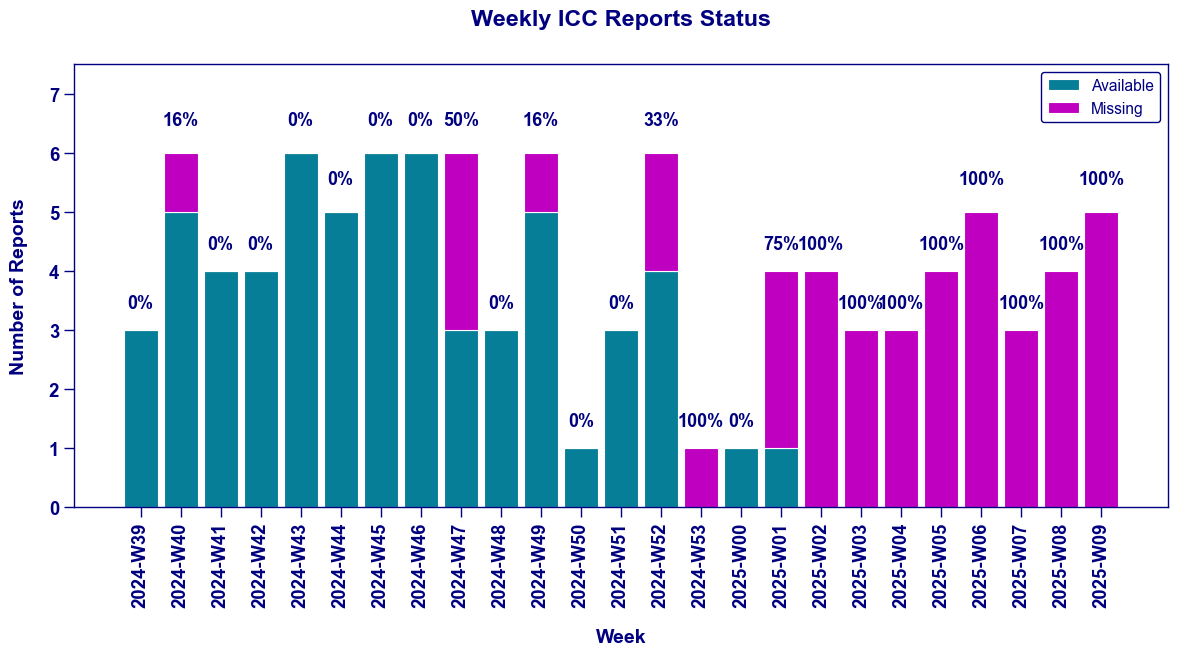

In [4]:
df = clean_icc_data(icc_df)
weekly_summary = generate_weekly_summary(df)
plot_icc_report(weekly_summary)